In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from neo4j import GraphDatabase
import collections
import matplotlib.pyplot as plt
from collections import Counter
from tabulate import tabulate

In [2]:
driver = GraphDatabase.driver('bolt://localhost:7687', auth=("neo4j", "test"))

In [3]:
query_all="MATCH (n)-[r]->(c) RETURN *"
query_intermediaries="MATCH (n: Entity)-[r]->(c) RETURN n,r"
query_singleton="MATCH (n) WHERE NOT (n)--() RETURN n;"
query_intermediaries="MATCH p=()-[r:INTERMEDIARY_OF]->() RETURN p"
query_officers="MATCH p=()-[r:OFFICER_OF|DIRECTOR_OF|BENEFICIARY_OF|SHAREHOLDER_OF]->() RETURN p"
query="MATCH (n)-[r]->(c) RETURN * LIMIT 25"
query_test="MATCH (n) - [r] -> (c)WHERE NOT c:address RETURN *"

In [4]:
results = driver.session(database="panama").run(query_test)
results

In [5]:
G = nx.Graph()

nodes = list(results.graph()._nodes.values())
for node in nodes:
    G.add_node(node.id, kind=list(node.labels)[0], properties=node._properties)

rels = list(results.graph()._relationships.values())
for rel in rels:
    G.add_edge(rel.start_node.id, rel.end_node.id, key=rel.id, type=rel.type, properties=rel._properties)

In [6]:
len(G.nodes)

559432

In [7]:
labels = {}
for n, d in G.nodes(data=True):
    l = d['kind']
    labels[l] = labels.get(l, [])
    labels[l].append(n)
print('Number of Entity nodes:', len(labels['Entity']), ' ====> Proportion(%):', round(len(labels['Entity'])/len(G.nodes)*100,2))
print('Number of Officer nodes:', len(labels['Officer']),' ====> Proportion(%):', round(len(labels['Officer'])/len(G.nodes)*100,2))
print('Number of Intermediary nodes:', len(labels['Intermediary']), ' ====> Proportion(%):', round(len(labels['Intermediary'])/len(G.nodes)*100,2))

Number of Entity nodes: 213634  ====> Proportion(%): 38.19
Number of Officer nodes: 238282  ====> Proportion(%): 42.59
Number of Intermediary nodes: 14074  ====> Proportion(%): 2.52


In [8]:
## Checking graph connectivity
nx.is_connected(G)

False

In [9]:
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

Number of nodes:  559432
Number of edges:  657483


In [10]:
# Graph connected components
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

In [11]:
print('The total number of components is: ',len(S))

The total number of components is:  11043


In [12]:
nodes_per_component = []
for subgraph in S:
    nodes_per_component.append(subgraph.number_of_nodes())

In [14]:
dfr = pd.DataFrame.from_dict(Counter(nodes_per_component), orient='index')
dfr.sort_index(inplace=True)
dfr.rename(columns={0: 'Occurrences'},inplace=True)
print(tabulate(dfr, headers='keys', tablefmt='psql'))

+--------+---------------+
|        |   Occurrences |
|--------+---------------|
|      2 |          3807 |
|      3 |          1483 |
|      4 |          1158 |
|      5 |           738 |
|      6 |           755 |
|      7 |           435 |
|      8 |           383 |
|      9 |           255 |
|     10 |           202 |
|     11 |           189 |
|     12 |           148 |
|     13 |           135 |
|     14 |           107 |
|     15 |            85 |
|     16 |            90 |
|     17 |            79 |
|     18 |            49 |
|     19 |            53 |
|     20 |            44 |
|     21 |            52 |
|     22 |            46 |
|     23 |            41 |
|     24 |            25 |
|     25 |            26 |
|     26 |            27 |
|     27 |            32 |
|     28 |            19 |
|     29 |            18 |
|     30 |            26 |
|     31 |            24 |
|     32 |            14 |
|     33 |            22 |
|     34 |            12 |
|     35 |            17 |
|

In [15]:
histogram_components = np.array(nodes_per_component)
largest_value = histogram_components.max()
print("The greatest component has " + str(largest_value) + " nodes.")

The greatest component has 455478 nodes.


In [16]:
Counter(nodes_per_component)

Counter({455478: 1,
         44: 11,
         4: 1158,
         6: 755,
         48: 9,
         304: 1,
         11: 189,
         9: 255,
         27: 32,
         260: 1,
         21: 52,
         13: 135,
         75: 4,
         163: 4,
         7: 435,
         10: 202,
         36: 15,
         139: 5,
         50: 4,
         378: 1,
         37: 16,
         32: 14,
         82: 2,
         14: 107,
         35: 17,
         2: 3807,
         2995: 1,
         17: 79,
         104: 3,
         45: 9,
         74: 5,
         30: 26,
         68: 2,
         3: 1483,
         66: 2,
         97: 3,
         89: 3,
         5: 738,
         94: 2,
         23: 41,
         15: 85,
         12: 148,
         42: 9,
         31: 24,
         270: 1,
         26: 27,
         69: 3,
         18: 49,
         96: 3,
         39: 16,
         8: 383,
         71: 3,
         114: 1,
         19: 53,
         41: 12,
         77: 5,
         190: 1,
         230: 2,
         409: 1,
 

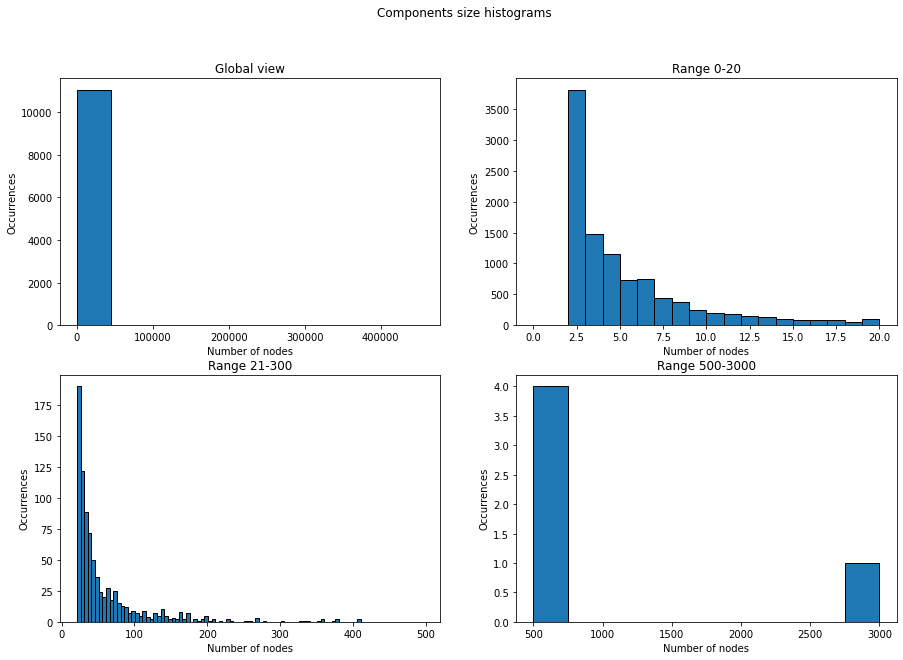

In [17]:
histogram_components = np.array(nodes_per_component)
fig, axs = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Components size histograms')
axs[0, 0].hist(histogram_components,ec="k")
axs[0, 0].set_title('Global view')
axs[0, 1].hist(histogram_components,ec="k",bins=list(range(0, 21, 1)),range=[0,20])
axs[0, 1].set_title('Range 0-20')
axs[1, 0].hist(histogram_components,ec="k",range=[21,500],bins=list(range(21, 500, 5)))
axs[1, 0].set_title('Range 21-300')
axs[1, 1].hist(histogram_components,ec="k",range=[500,3000])
axs[1, 1].set_title('Range 500-3000')

for ax in axs.flat:
    ax.set(xlabel='Number of nodes', ylabel='Occurrences')
plt.show()

Vemos que contamos con más de 10000 componentes con més de 300 nodos. Por ello, y dado que existe una gran componente con más de 400000 nodos, no los tendremos en cuenta para el estudio.

In [18]:
## Remove small comunities
for subgraph in S:
    if subgraph.number_of_nodes() < 3000:
        G.remove_nodes_from(list(subgraph.nodes))
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
G = S[0]

1


In [25]:
dfr = pd.DataFrame.from_dict(Counter(list(dict(nx.degree(G)).values())), orient='index')
dfr.sort_index(inplace=True)
dfr.rename(columns={0: 'Occurrences degree'},inplace=True)
print(tabulate(dfr, headers='keys', tablefmt='psql'))

+------+----------------------+
|      |   Occurrences degree |
|------+----------------------|
|    1 |               193746 |
|    2 |               178155 |
|    3 |                42433 |
|    4 |                15343 |
|    5 |                11633 |
|    6 |                 4263 |
|    7 |                 2643 |
|    8 |                 1423 |
|    9 |                  947 |
|   10 |                  624 |
|   11 |                  565 |
|   12 |                  394 |
|   13 |                  283 |
|   14 |                  219 |
|   15 |                  188 |
|   16 |                  163 |
|   17 |                  148 |
|   18 |                  106 |
|   19 |                  105 |
|   20 |                  107 |
|   21 |                  113 |
|   22 |                   85 |
|   23 |                   72 |
|   24 |                   79 |
|   25 |                   64 |
|   26 |                   66 |
|   27 |                   53 |
|   28 |                   50 |
|   29 |

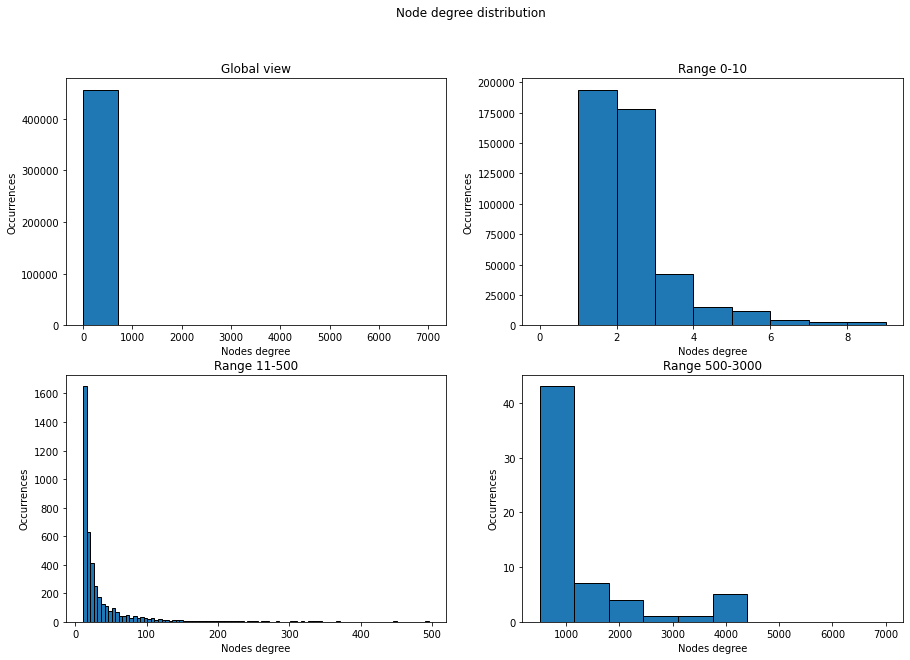

In [63]:
histogram_degrees = list(dict(nx.degree(G)).values())
fig, axs = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Node degree distribution')
axs[0, 0].hist(histogram_degrees,ec="k")
axs[0, 0].set_title('Global view')
axs[0, 1].hist(histogram_degrees,ec="k",bins=list(range(0, 10, 1)),range=[0,10])
axs[0, 1].set_title('Range 0-10')
axs[1, 0].hist(histogram_degrees,ec="k",range=[10,500],bins=list(range(11, 500, 5)))
axs[1, 0].set_title('Range 11-500')
axs[1, 1].hist(histogram_degrees,ec="k",range=[500,7000])
axs[1, 1].set_title('Range 500-3000')

for ax in axs.flat:
    ax.set(xlabel='Nodes degree', ylabel='Occurrences')
plt.show()

In [64]:
labels = {}
for n, d in G.nodes(data=True):
    l = d['kind']
    labels[l] = labels.get(l, [])
    labels[l].append(n)
print('Number of Entity nodes:', len(labels['Entity']), ' ====> Proportion(%):', round(len(labels['Entity'])/len(G.nodes)*100,2))
print('Number of Officer nodes:', len(labels['Officer']),' ====> Proportion(%):', round(len(labels['Officer'])/len(G.nodes)*100,2))
print('Number of Intermediary nodes:', len(labels['Intermediary']), ' ====> Proportion(%):', round(len(labels['Intermediary'])/len(G.nodes)*100,2))

Number of Entity nodes: 169676  ====> Proportion(%): 37.25
Number of Officer nodes: 200769  ====> Proportion(%): 44.08
Number of Intermediary nodes: 3096  ====> Proportion(%): 0.68


In [65]:
dfr_entity = pd.DataFrame.from_dict(Counter(list(dict(G.degree(labels['Entity'])).values())), orient='index')
dfr_entity.sort_index(inplace=True)
dfr_entity.rename(columns={0: 'Occurrences degree'},inplace=True)
print(tabulate(dfr_entity, headers='keys', tablefmt='psql'))

+------+----------------------+
|      |   Occurrences degree |
|------+----------------------|
|    1 |                62353 |
|    2 |                44960 |
|    3 |                32174 |
|    4 |                11751 |
|    5 |                 9971 |
|    6 |                 3242 |
|    7 |                 1957 |
|    8 |                  957 |
|    9 |                  606 |
|   10 |                  334 |
|   11 |                  344 |
|   12 |                  213 |
|   13 |                  127 |
|   14 |                   84 |
|   15 |                   68 |
|   16 |                   55 |
|   17 |                   47 |
|   18 |                   29 |
|   19 |                   20 |
|   20 |                   22 |
|   21 |                   45 |
|   22 |                   34 |
|   23 |                   15 |
|   24 |                   17 |
|   25 |                   13 |
|   26 |                   19 |
|   27 |                   13 |
|   28 |                   10 |
|   29 |

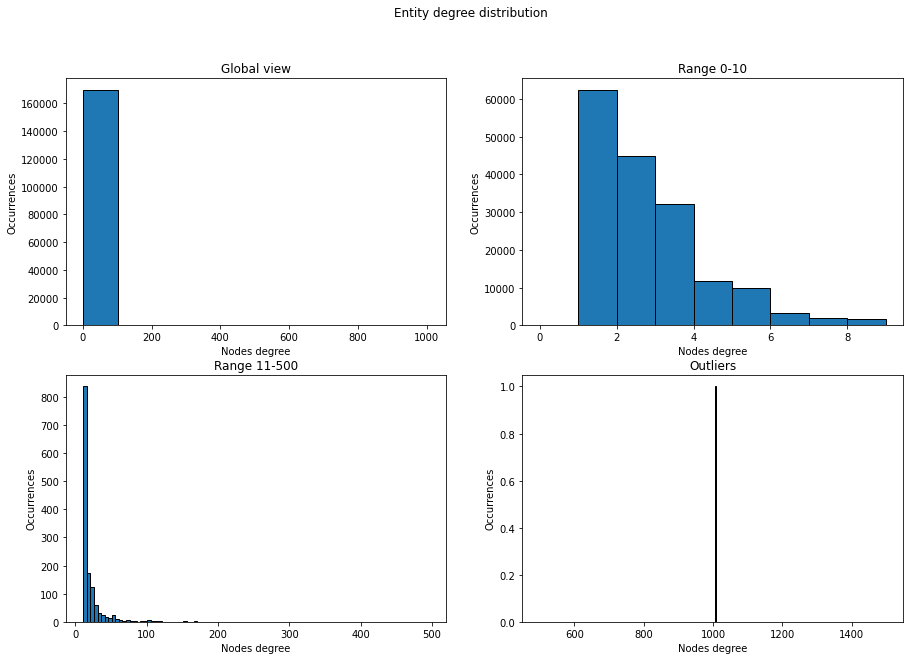

In [66]:
histogram_degrees_entity = list(dict(G.degree(labels['Entity'])).values())
fig, axs = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Entity degree distribution')
axs[0, 0].hist(histogram_degrees_entity,ec="k")
axs[0, 0].set_title('Global view')
axs[0, 1].hist(histogram_degrees_entity,ec="k",bins=list(range(0, 10, 1)),range=[0,10])
axs[0, 1].set_title('Range 0-10')
axs[1, 0].hist(histogram_degrees_entity,ec="k",range=[10,500],bins=list(range(11, 500, 5)))
axs[1, 0].set_title('Range 11-500')
axs[1, 1].hist(histogram_degrees_entity,ec="k",range=[500,1500],bins=list(range(500, 1500, 2)))
axs[1, 1].set_title('Outliers')

for ax in axs.flat:
    ax.set(xlabel='Nodes degree', ylabel='Occurrences')
plt.show()

In [67]:
dfr_officer = pd.DataFrame.from_dict(Counter(list(dict(G.degree(labels['Officer'])).values())), orient='index')
dfr_officer.sort_index(inplace=True)
dfr_officer.rename(columns={0: 'Occurrences degree'},inplace=True)
print(tabulate(dfr, headers='keys', tablefmt='psql'))

+------+----------------------+
|      |   Occurrences degree |
|------+----------------------|
|    1 |                67128 |
|    2 |               120673 |
|    3 |                 7597 |
|    4 |                 2063 |
|    5 |                  926 |
|    6 |                  535 |
|    7 |                  358 |
|    8 |                  225 |
|    9 |                  160 |
|   10 |                  120 |
|   11 |                  106 |
|   12 |                   80 |
|   13 |                   72 |
|   14 |                   52 |
|   15 |                   51 |
|   16 |                   44 |
|   17 |                   51 |
|   18 |                   43 |
|   19 |                   40 |
|   20 |                   46 |
|   21 |                   28 |
|   22 |                   15 |
|   23 |                   23 |
|   24 |                   27 |
|   25 |                   19 |
|   26 |                   17 |
|   27 |                   16 |
|   28 |                   11 |
|   29 |

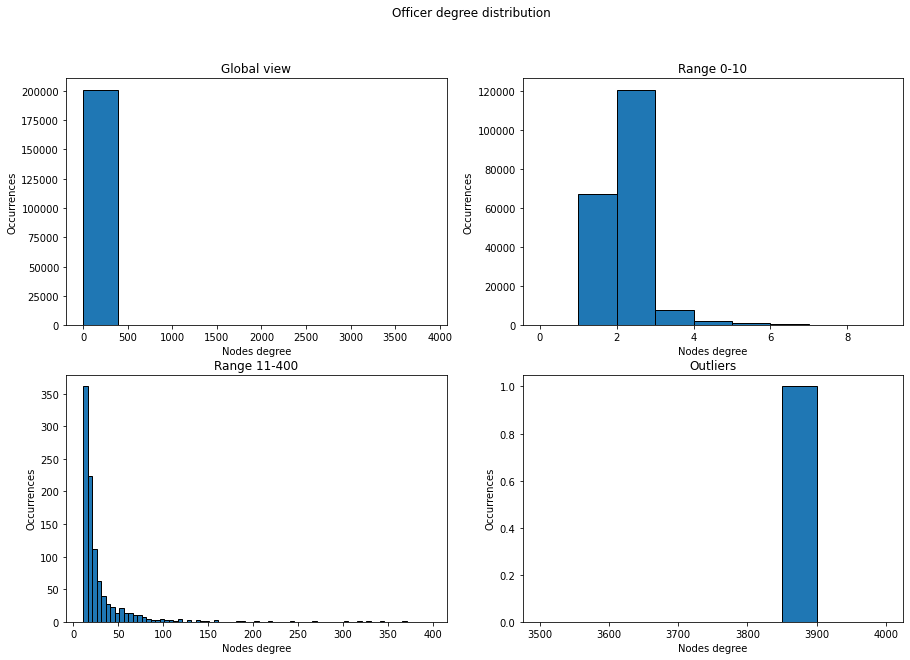

In [68]:
histogram_degrees_officer = list(dict(G.degree(labels['Officer'])).values())
fig, axs = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Officer degree distribution')
axs[0, 0].hist(histogram_degrees_officer,ec="k")
axs[0, 0].set_title('Global view')
axs[0, 1].hist(histogram_degrees_officer,ec="k",bins=list(range(0, 10, 1)),range=[0,10])
axs[0, 1].set_title('Range 0-10')
axs[1, 0].hist(histogram_degrees_officer,ec="k",range=[10,400],bins=list(range(11, 400, 5)))
axs[1, 0].set_title('Range 11-400')
axs[1, 1].hist(histogram_degrees_officer,ec="k",range=[3500,4000])
axs[1, 1].set_title('Outliers')

for ax in axs.flat:
    ax.set(xlabel='Nodes degree', ylabel='Occurrences')
plt.show()

In [69]:
dfr_intermediary = pd.DataFrame.from_dict(Counter(list(dict(G.degree(labels['Intermediary'])).values())), orient='index')
dfr_officer.sort_index(inplace=True)
dfr_officer.rename(columns={0: 'Occurrences degree'},inplace=True)
print(tabulate(dfr, headers='keys', tablefmt='psql'))

+------+----------------------+
|      |   Occurrences degree |
|------+----------------------|
|    1 |                67128 |
|    2 |               120673 |
|    3 |                 7597 |
|    4 |                 2063 |
|    5 |                  926 |
|    6 |                  535 |
|    7 |                  358 |
|    8 |                  225 |
|    9 |                  160 |
|   10 |                  120 |
|   11 |                  106 |
|   12 |                   80 |
|   13 |                   72 |
|   14 |                   52 |
|   15 |                   51 |
|   16 |                   44 |
|   17 |                   51 |
|   18 |                   43 |
|   19 |                   40 |
|   20 |                   46 |
|   21 |                   28 |
|   22 |                   15 |
|   23 |                   23 |
|   24 |                   27 |
|   25 |                   19 |
|   26 |                   17 |
|   27 |                   16 |
|   28 |                   11 |
|   29 |

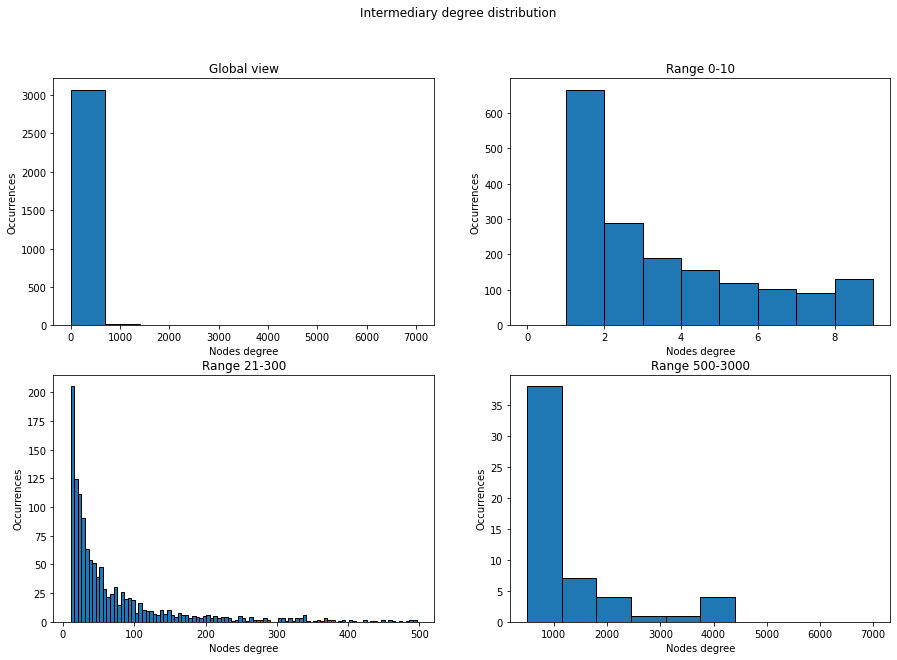

In [72]:
histogram_degrees_intermediaries = list(dict(G.degree(labels['Intermediary'])).values())
fig, axs = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Intermediary degree distribution')
axs[0, 0].hist(histogram_degrees_intermediaries,ec="k")
axs[0, 0].set_title('Global view')
axs[0, 1].hist(histogram_degrees_intermediaries,ec="k",bins=list(range(0, 10, 1)),range=[0,10])
axs[0, 1].set_title('Range 0-10')
axs[1, 0].hist(histogram_degrees_intermediaries,ec="k",range=[10,500],bins=list(range(11, 500, 5)))
axs[1, 0].set_title('Range 21-300')
axs[1, 1].hist(histogram_degrees_intermediaries,ec="k",range=[500,7000])
axs[1, 1].set_title('Range 500-3000')

for ax in axs.flat:
    ax.set(xlabel='Nodes degree', ylabel='Occurrences')
plt.show()

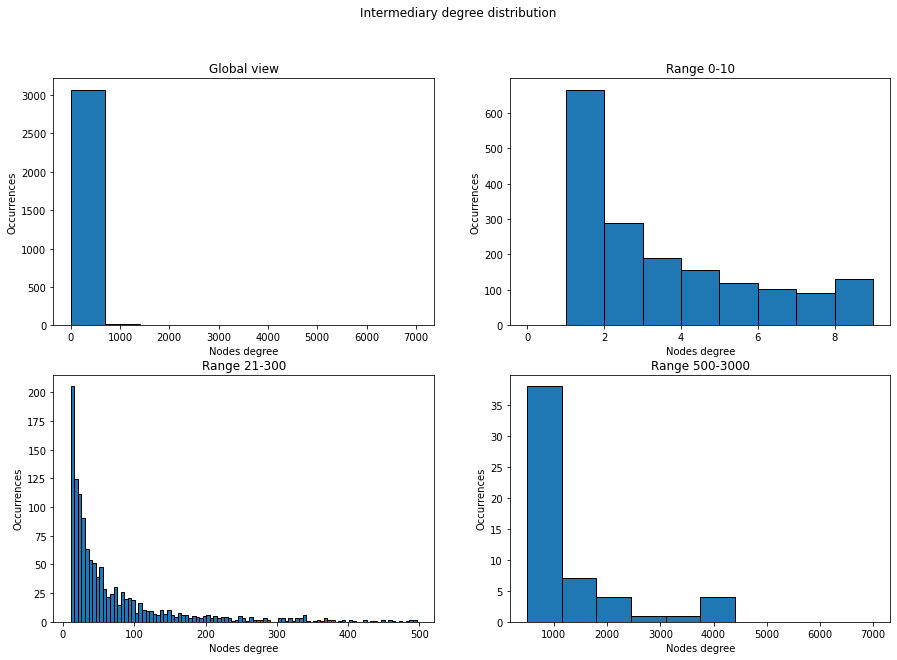

In [78]:
histogram_degrees_intermediaries = list(dict(G.degree(labels['Intermediary'])).values())
fig, axs = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Intermediary degree distribution')
axs[0, 0].hist(histogram_degrees_intermediaries,ec="k")
axs[0, 0].set_title('Global view')
axs[0, 1].hist(histogram_degrees_intermediaries,ec="k",bins=list(range(0, 10, 1)),range=[0,10])
axs[0, 1].set_title('Range 0-10')
axs[1, 0].hist(histogram_degrees_intermediaries,ec="k",range=[10,500],bins=list(range(11, 500, 5)))
axs[1, 0].set_title('Range 21-300')
axs[1, 1].hist(histogram_degrees_intermediaries,ec="k",range=[500,7000])
axs[1, 1].set_title('Range 500-3000')

for ax in axs.flat:
    ax.set(xlabel='Nodes degree', ylabel='Occurrences')
plt.show()

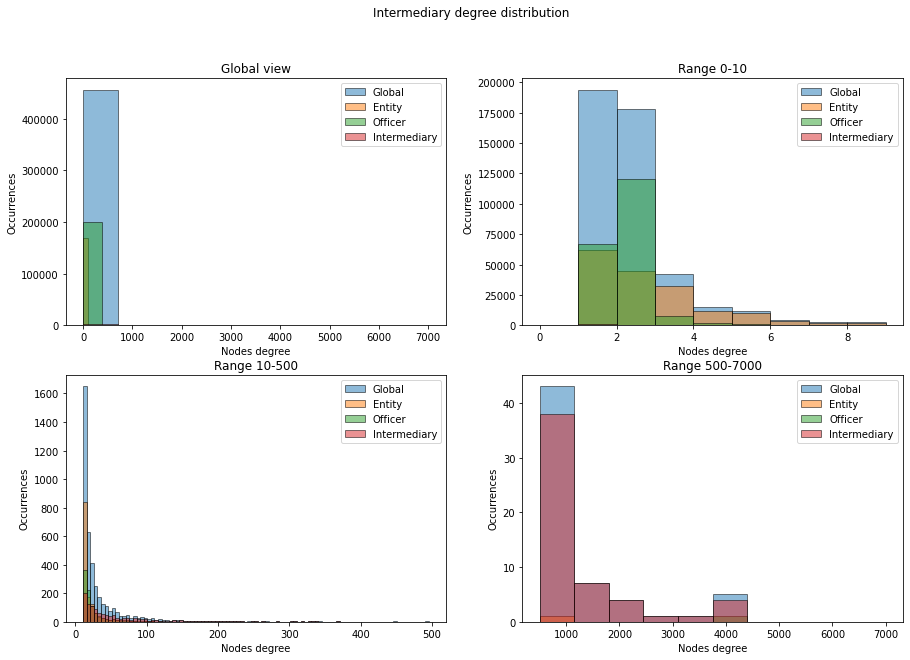

In [93]:
histogram_degrees_intermediaries = list(dict(G.degree(labels['Intermediary'])).values())
fig, axs = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Intermediary degree distribution')
axs[0, 0].hist(histogram_degrees,ec="k",alpha=0.5,label="Global")
axs[0, 0].hist(histogram_degrees_entity,ec="k",alpha=0.5,label="Entity")
axs[0, 0].hist(histogram_degrees_officer,ec="k",alpha=0.5,label="Officer")
axs[0, 0].hist(histogram_degrees_intermediaries,ec="k",alpha=0.5,label="Intermediary")
axs[0, 0].set_title('Global view')
#axs[0, 0].legend()
axs[0, 1].hist(histogram_degrees,ec="k",bins=list(range(0, 10, 1)),range=[0,10],alpha=0.5,label="Global")
axs[0, 1].hist(histogram_degrees_entity,ec="k",bins=list(range(0, 10, 1)),range=[0,10],alpha=0.5,label="Entity")
axs[0, 1].hist(histogram_degrees_officer,ec="k",bins=list(range(0, 10, 1)),range=[0,10],alpha=0.5,label="Officer")
axs[0, 1].hist(histogram_degrees_intermediaries,ec="k",bins=list(range(0, 10, 1)),range=[0,10],alpha=0.5,label="Intermediary")
axs[0, 1].set_title('Range 0-10')
#axs[0, 1].legend()
axs[1, 0].hist(histogram_degrees,ec="k",range=[10,500],bins=list(range(11, 500, 5)),alpha=0.5,label="Global")
axs[1, 0].hist(histogram_degrees_entity,ec="k",range=[10,500],bins=list(range(11, 500, 5)),alpha=0.5,label="Entity")
axs[1, 0].hist(histogram_degrees_officer,ec="k",range=[10,500],bins=list(range(11, 500, 5)),alpha=0.5,label="Officer")
axs[1, 0].hist(histogram_degrees_intermediaries,ec="k",range=[10,500],bins=list(range(11, 500, 5)),alpha=0.5,label="Intermediary")
axs[1, 0].set_title('Range 10-500')
#axs[1, 0].legend()
axs[1, 1].hist(histogram_degrees,ec="k",range=[500,7000],alpha=0.5,label="Global")
axs[1, 1].hist(histogram_degrees_entity,ec="k",range=[500,7000],alpha=0.5,label="Entity")
axs[1, 1].hist(histogram_degrees_officer,ec="k",range=[500,7000],alpha=0.5,label="Officer")
axs[1, 1].hist(histogram_degrees_intermediaries,ec="k",range=[500,7000],alpha=0.5,label="Intermediary")
axs[1, 1].set_title('Range 500-7000')
#axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='Nodes degree', ylabel='Occurrences')
    ax.legend()
plt.show()

In [141]:
for node_id,metadata in G.nodes(data=True):
    print(G[node_id])
    break
    if G.degree(node_id) == 7016:
        print(metadata)

{215080: {'key': 503988, 'type': 'INTERMEDIARY_OF', 'properties': {'detail': 'intermediary of'}}, 511731: {'key': 244927, 'type': 'SHAREHOLDER_OF', 'properties': {'detail': 'shareholder of'}}, 439311: {'key': 135846, 'type': 'SHAREHOLDER_OF', 'properties': {'detail': 'shareholder of'}}}


In [149]:
scatter_associativity = []
scatter_associativity_entity = []
scatter_associativity_officer = []
scatter_associativity_intermediary = []
for node_id,metadata in G.nodes(data=True):
    node_degree = G.degree(node_id)
    for node_neighbor in G.neighbors(node_id):
        neighbor_degree = G.degree(node_neighbor)
        scatter_associativity.append(list([node_degree, neighbor_degree]))
        if G.nodes[node_neighbor]['kind'] == 'Entity':
            scatter_associativity_entity.append(list([node_degree, neighbor_degree]))
        elif G.nodes[node_neighbor]['kind'] == 'Officer':
            scatter_associativity_officer.append(list([node_degree, neighbor_degree]))
        else:
            scatter_associativity_intermediary.append(list([node_degree, neighbor_degree]))            


In [151]:
print('Number of spatial points regarding of overall network: ',len(scatter_associativity))
print('Number of spatial points regarding of entities: ',len(scatter_associativity_entity))
print('Number of spatial points regarding of officers: ',len(scatter_associativity_officer))
print('Number of spatial points regarding of intermediaries: ', len(scatter_associativity_intermediary))

Number of spatial points regarding of overall network:  1115970
Number of spatial points regarding of entities:  425739
Number of spatial points regarding of officers:  386324
Number of spatial points regarding of intermediaries:  303907


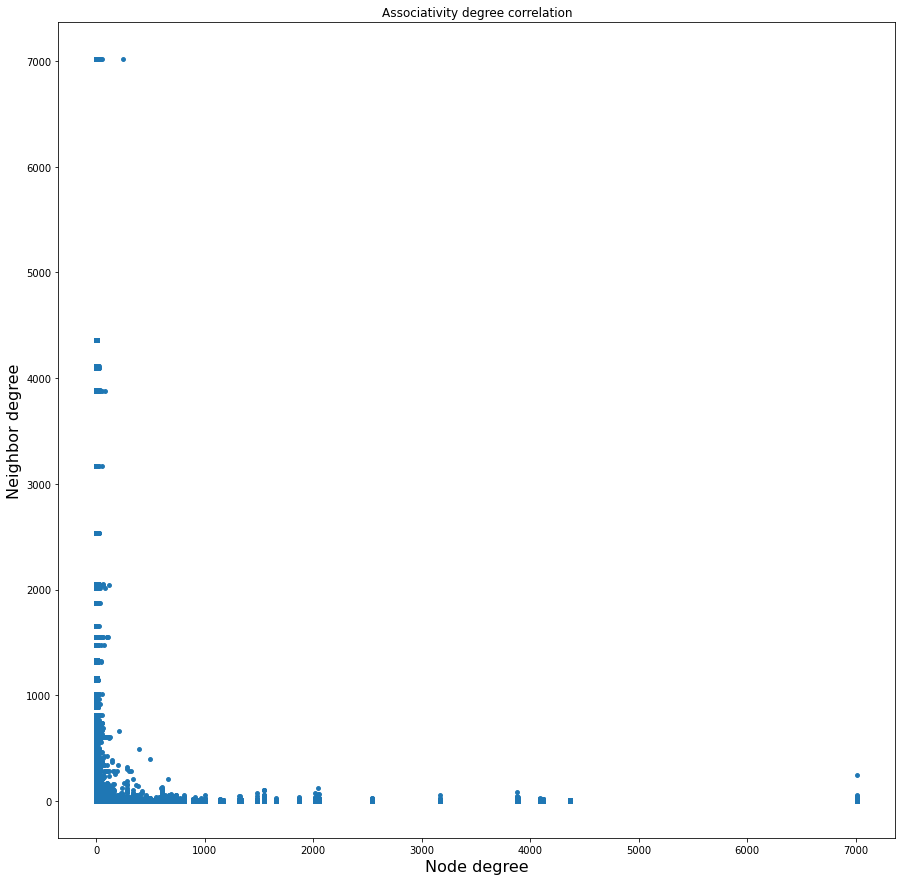

In [197]:
fig, axs = plt.subplots(1,1,figsize=(15,15))
x,y = (np.array(scatter_associativity)).T
plt.scatter(x,y,s=15)
plt.title('Associativity degree correlation')
plt.xlabel('Node degree', fontsize=16)
plt.ylabel('Neighbor degree', fontsize=16)
plt.show()

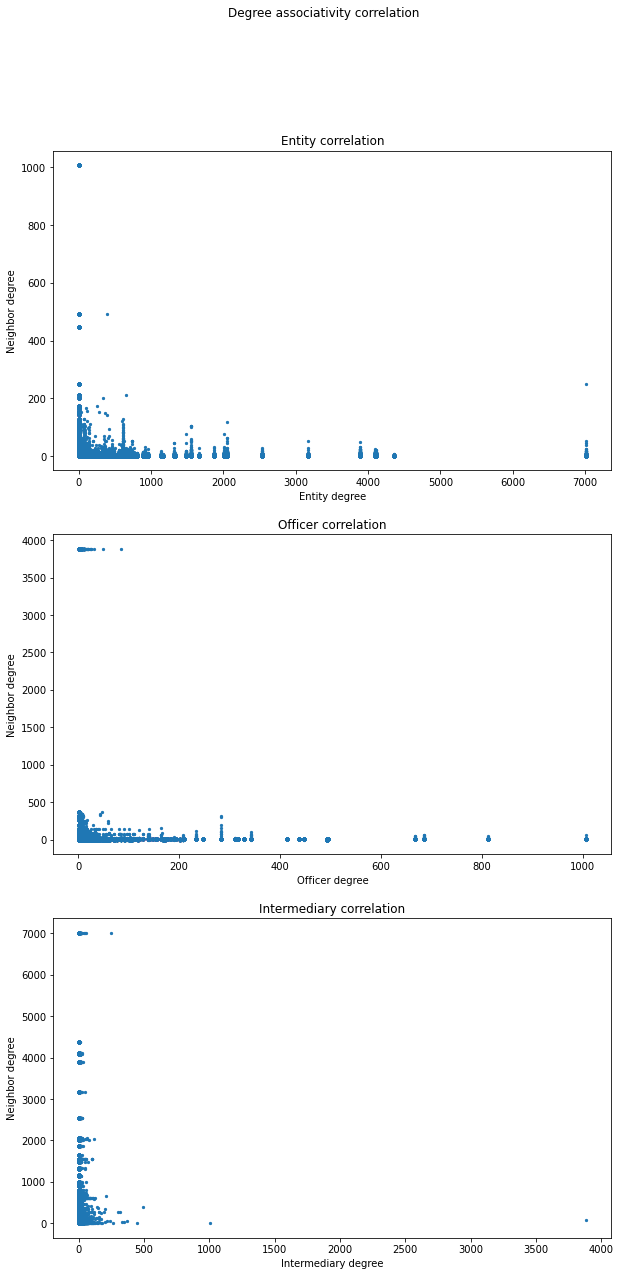

In [184]:
x_entity,y_entity = (np.array(scatter_associativity_entity)).T
x_officer,y_officer = (np.array(scatter_associativity_officer)).T
x_intermediary,y_intermediary = (np.array(scatter_associativity_intermediary)).T

fig, axs = plt.subplots(3,1,figsize=(10,20))
fig.suptitle('Degree associativity correlation')

axs[0].scatter(x_entity,y_entity,label="Entity",s=5)
axs[0].set_title('Entity correlation')
axs[0].set(xlabel='Entity degree', ylabel='Neighbor degree')
axs[1].scatter(x_officer,y_officer,label="Officer",s=5)
axs[1].set_title('Officer correlation')
axs[1].set(xlabel='Officer degree', ylabel='Neighbor degree')
axs[2].scatter(x_intermediary,y_intermediary,label="Intermediary",s=5)
axs[2].set_title('Intermediary correlation')
axs[2].set(xlabel='Intermediary degree', ylabel='Neighbor degree')
plt.show()

In [205]:
type(axs)

matplotlib.axes._subplots.AxesSubplot

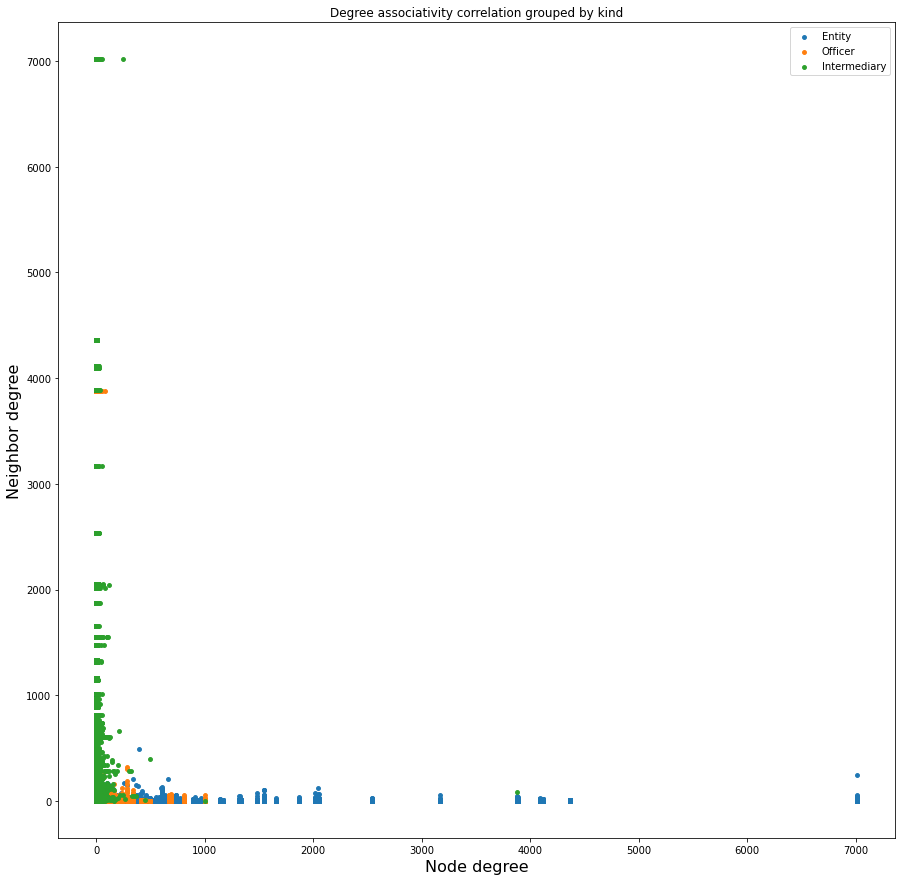

In [201]:
fig, axs = plt.subplots(1,1,figsize=(15,15))

plt.scatter(x_entity,y_entity,s=15,label="Entity")
plt.scatter(x_officer,y_officer,s=15,label="Officer")
plt.scatter(x_intermediary,y_intermediary,s=15,label="Intermediary")
plt.xlabel('Node degree', fontsize=16)
plt.ylabel('Neighbor degree', fontsize=16)
plt.title('Degree associativity correlation grouped by kind')
plt.legend()
plt.show()

In [18]:
def get_stats(stats):
    array = list(stats.values())
    response = {
        "min": min(array),
        "max": max(array),
        "mean": np.mean(array),
        "std": np.std(array)
    }
    return response

In [19]:
## Degree centrality
stats_degree_centrality = get_stats(nx.degree_centrality(G))
print(stats_degree_centrality)

{'min': 1.787530544428178e-06, 'max': 0.012541314299708096, 'mean': 4.201657913534699e-06, 'std': 3.6476015283729266e-05}


In [ ]:
## Information centrality
stats_information_centrality_dict = {}
for i in S:
    stats_information_centrality_dict.update(nx.information_centrality(i))
stats_information_centrality = get_stats(stats_information_centrality_dict)
print(stats_information_centrality)

In [ ]:
## Closeness centrality
stats_closeness_centrality = get_stats(nx.closeness_centrality(G))
print(stats_closeness_centrality)

In [34]:
## Betwenness centrality
stats_betweenness_centrality = get_stats(nx.betweenness_centrality(G, k=100))
print(stats_betweenness_centrality)

{'min': 0.0, 'max': 0.005993031358885017, 'mean': 0.0003252032520325203, 'std': 0.0012874709835587474}


In [35]:
stats_current_flow_closeness_centrality_dict = {}
for i in S:
    stats_current_flow_closeness_centrality_dict.update(nx.current_flow_closeness_centrality(i))
stats_current_flow_closeness_centrality = get_stats(stats_current_flow_closeness_centrality_dict)
print(stats_current_flow_closeness_centrality)

{'min': 0.14285714285714285, 'max': 1.0, 'mean': 0.7462347729789589, 'std': 0.353534832443594}


In [46]:
for i in S:
    if i.number_of_nodes() < 300:
        G.remove_nodes_from(list(i.nodes))

In [47]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print(len(S))

18


In [49]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
print ("Degree sequence", degree_sequence)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

Degree sequence [7016, 4364, 4117, 4094, 3888, 3883, 3168, 2986, 2538, 2055, 2045, 2014, 1871, 1659, 1550, 1479, 1335, 1323, 1315, 1166, 1140, 1007, 1007, 963, 918, 912, 892, 813, 806, 777, 768, 736, 732, 729, 721, 703, 700, 691, 689, 686, 680, 667, 659, 658, 657, 632, 619, 611, 607, 603, 594, 588, 586, 584, 578, 575, 569, 564, 555, 554, 542, 541, 540, 496, 495, 493, 493, 490, 486, 481, 474, 465, 458, 456, 450, 448, 448, 438, 436, 435, 424, 422, 414, 406, 405, 404, 394, 393, 387, 380, 377, 375, 373, 371, 370, 369, 369, 367, 361, 361, 358, 356, 351, 344, 343, 342, 340, 339, 338, 338, 338, 337, 337, 334, 333, 331, 331, 330, 329, 328, 327, 326, 323, 318, 317, 317, 316, 316, 313, 310, 309, 309, 306, 305, 305, 302, 301, 290, 289, 284, 283, 283, 281, 279, 276, 273, 272, 270, 266, 266, 265, 265, 264, 263, 259, 255, 251, 251, 250, 249, 248, 246, 246, 246, 244, 243, 241, 236, 235, 234, 233, 231, 231, 230, 229, 229, 228, 223, 222, 222, 221, 220, 219, 217, 216, 215, 211, 211, 211, 211, 210, 209, 